# CS412 - Machine Learning - Fall 2025
## Homework 3


## Dataset
[**CelebA**](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) is a large-scale face attributes dataset with more than 200K celebrity images, each with 40 attribute annotations. The images in this dataset cover large pose variations and background clutter.

**Download the data from Sucourse and upload it to your Google Drive. You must upload both CelebA30k.zip and CelebA30k.csv to your Drive without renaming them.
CelebA30k is a smaller version of the original CelebA dataset, containing 30,000 images, to reduce computation time during training.
Split the data as follows: reserve 10% of the samples for validation and 10% for testing (i.e., 3,000 samples). The remaining 80% should be used for training.
Important: The test set (3,000 samples) must be used only for final evaluation and not for model selection or hyperparameter tuning.**

## Task

The task in this homework is to perform binary **smiling** classification on a subset of the CelebA dataset using transfer learning.

A pretrained VGG-16 model will be adapted to the task, and its performance will be evaluated under several settings. You will replace the classification head with a binary output layer and train the model for a fixed number of 10 epochs per configuration.

You must:
- Freeze appropriate parts of the pretrained model according to the strategy you choose and only modify the classification head.
- Evaluate your models using the following hyperparameters:
  - 10 epochs
  - Learning rate: 0.0001
  - Fine-tuning strategies:
    1. Freeze all convolutional layers and train only the classifier head.
    2. Freeze all weights except the last convolutional block and the classifier head, and fine-tune those parameters.
- Apply Random Horizontal Flip and a light Color Jitter during training, then discuss how these augmentations affect the smiling classification performance.

**Dataset:** CelebA  
**Model:** VGG-16  
**Library:** PyTorch  

---

## Software

You will use the PyTorch framework for this homework. PyTorch offers flexible tools for deep learning, including pretrained models, custom training loops, and GPU acceleration.


## 1) Initialize

*   First make a copy of the notebook given to you as a starter.

*   Make sure you change your runtime to GPU.

## 2) Load training dataset

In [1]:
# load data
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# Import necessary libraries
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms

from torch.utils.data import DataLoader, Dataset

# For reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%matplotlib inline

In [5]:

data = pd.read_csv('/content/drive/My Drive/CS412_HW3/CelebA30k.csv')
data.head()

,filename,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [33]:
smile_data = data[['filename', 'Smiling']].copy()
smile_data.head()

,filename,Smiling
0,000001.jpg,1
1,000002.jpg,1
2,000003.jpg,-1
3,000004.jpg,-1
4,000005.jpg,-1


In [8]:
import os

# Unzip ONCE into /content/data
zip_path = "/content/drive/My Drive/CelebA30k.zip"
target_dir = "/content/data/CelebA30k"

if not os.path.exists(target_dir):
    print("Extracting dataset")
    !unzip -q "{zip_path}" -d "/content/data"
    print("Extraction complete")
else:
    print("Dataset already extracted, skipping unzip.")

# Set image directory
img_dir = target_dir
print("Using dataset at:", img_dir)

Extracting dataset
unzip:  cannot find or open /content/drive/My Drive/CelebA30k.zip, /content/drive/My Drive/CelebA30k.zip.zip or /content/drive/My Drive/CelebA30k.zip.ZIP.
Extraction complete
Using dataset at: /content/data/CelebA30k


In [23]:
import os
import zipfile
from google.colab import drive

# 1. Mount Drive
drive.mount('/content/drive')

# 2. Search for the Zip File (Auto-detect)
print("Searching for CelebA30k.zip in Google Drive...")
found_zip_path = None

# Walk through Drive to find the zip file
for root, dirs, files in os.walk("/content/drive"):
    if "CelebA30k.zip" in files:
        found_zip_path = os.path.join(root, "CelebA30k.zip")
        print(f" Zip file found: {found_zip_path}")
        break


else:
    # 3. Extract File (Unzip)
    extract_to = '/content/CelebA_dataset'
    print(f"Extracting file to: {extract_to} ...")

    if not os.path.exists(extract_to):
        os.makedirs(extract_to)

    with zipfile.ZipFile(found_zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print(" Extraction complete.")

    # 4. Verify Image Directory
    # Sometimes images are directly inside the zip, sometimes in a subfolder.
    # We check this to set img_dir correctly.
    img_dir = extract_to

    # Check if images are in a subfolder
    # Looking for sample image 000001.jpg
    sample_img = "000001.jpg"
    found_img = False

    for root, dirs, files in os.walk(extract_to):
        if sample_img in files:
            img_dir = root
            found_img = True
            break

    if found_img:
        print(f" Image directory successfully set to: {img_dir}")
        print("You can now proceed to the next step (Dataset creation).")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Searching for CelebA30k.zip in Google Drive...
 Zip file found: /content/drive/MyDrive/CS412_HW3/CelebA30k.zip


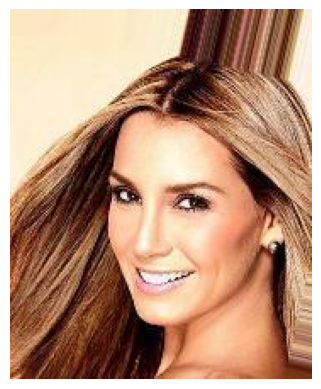

In [32]:
import os
from PIL import Image
import matplotlib.pyplot as plt

img_dir = '/content/CelebA_dataset/CelebA30k'

first_image_path = os.path.join(img_dir, smile_data.loc[0, "filename"])


img = Image.open(first_image_path)
plt.imshow(img)
plt.axis('off')
plt.show()



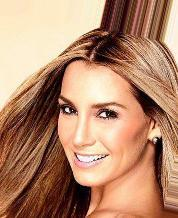

In [ ]:
img

# Starting here, you’ll need to fill in the code cells on your own.

## 3) Visualizing/Understanding the dataset

- Display five random images together with their smiling labels.
- Display statistics about the dataset, such as the distribution of smiling vs. not-smiling samples and any other attributes that you find informative.


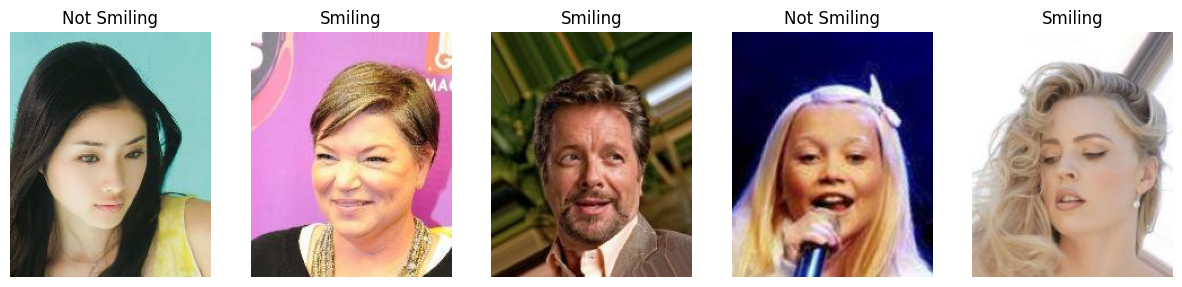

Class Distribution:
Smiling
-1    15741
 1    14259
Name: count, dtype: int64


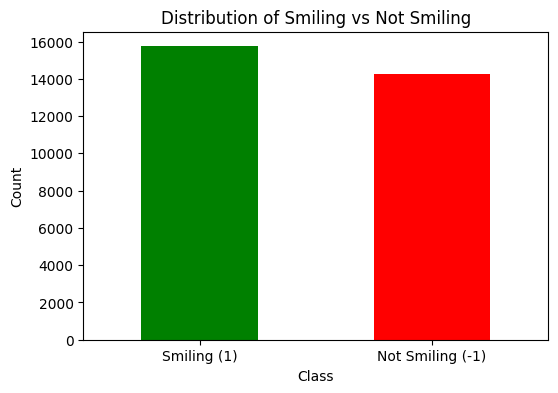

In [27]:
# 3) Visualizing/Understanding the dataset

# Select 5 random samples
random_samples = smile_data.sample(5)

fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i, (index, row) in enumerate(random_samples.iterrows()):
    img_path = os.path.join(img_dir, row['filename'])
    try:
        img = Image.open(img_path)
        axes[i].imshow(img)
        # Label 1 is Smiling, -1 is Not Smiling
        label = "Smiling" if row['Smiling'] == 1 else "Not Smiling"
        axes[i].set_title(label)
        axes[i].axis('off')
    except Exception as e:
        print(f"Could not load image: {img_path}")

plt.show()

# Statistics
print("Class Distribution:")
print(smile_data['Smiling'].value_counts())

# Visualization (Bar plot)
plt.figure(figsize=(6, 4))
smile_data['Smiling'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Distribution of Smiling vs Not Smiling')
plt.xticks(ticks=[0, 1], labels=['Smiling (1)', 'Not Smiling (-1)'], rotation=0)
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()



## 4) Split the dataset as train (80%), validation (10%) and test (10%) set.

In [28]:
# 4) Split the dataset

# First, separate the Test set (10% of total) -> 30,000 * 0.10 = 3000 images
train_val_df, test_df = train_test_split(
    smile_data,
    test_size=0.10,
    random_state=42,
    stratify=smile_data['Smiling']
)

# Now separate Validation from the remaining data
# Total validation target is 10% of original (3000 images).
# We have 27,000 images left. 3000 / 27000 = 1/9.
val_split_ratio = 1/9
train_df, val_df = train_test_split(
    train_val_df,
    test_size=val_split_ratio,
    random_state=42,
    stratify=train_val_df['Smiling']
)

print(f"Training Set Size: {len(train_df)}")
print(f"Validation Set Size: {len(val_df)}")
print(f"Test Set Size: {len(test_df)}")

Training Set Size: 24000
Validation Set Size: 3000
Test Set Size: 3000


## 5) Preparing the Data

In this section, you will implement the dataset loading and preprocessing pipeline using PyTorch.

You are provided with:
- `train_df` and `val_df` dataframes, which include two columns: `filename`  and `Smiling`
- A directory path (`/content/data/CelebA30k`) that contains the image files

Your task is to:
1. Define appropriate transformations using `torchvision.transforms` for the training and validation sets
   - Resize images to 224x224
   - Convert them to tensors
   - Normalize them (you can use `[0.5, 0.5, 0.5]` for simplicity)
   - Include `RandomHorizontalFlip` and a light `ColorJitter` (e.g., low brightness/contrast adjustments) for the training set to satisfy the augmentation requirement
2. Write a custom `Dataset` class that reads images and smiling labels from the dataframe
3. Create `DataLoader` objects for training and validation with an appropriate batch size.
4. Keep notes on how the applied augmentations might influence the smiling classification results so you can reflect on them in your discussion


In [29]:
# 5) Preparing the Data

# Convert labels to 0 and 1 (-1 -> 0, 1 -> 1) for Binary Cross Entropy
def process_labels(df):
    df = df.copy()
    df['label'] = df['Smiling'].apply(lambda x: 1 if x == 1 else 0)
    return df

train_df = process_labels(train_df)
val_df = process_labels(val_df)
test_df = process_labels(test_df)

class CelebADataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        # Open image and ensure RGB
        image = Image.open(img_name).convert('RGB')
        # Label is now in the new 'label' column (index might vary, safely accessing by name is better, but here assuming structure)
        label = int(self.dataframe.iloc[idx]['label'])

        if self.transform:
            image = self.transform(image)

        # Return float tensor for label (required for BCEWithLogitsLoss)
        return image, torch.tensor(label, dtype=torch.float32)

# Define Transforms
# VGG16 expects 224x224.
# PDF requires: Random Horizontal Flip and Color Jitter for training.
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Light color jitter
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Test/Val: Only Resize and Normalize
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create Datasets and DataLoaders
batch_size = 32

train_dataset = CelebADataset(train_df, img_dir, transform=train_transforms)
val_dataset = CelebADataset(val_df, img_dir, transform=test_transforms)
test_dataset = CelebADataset(test_df, img_dir, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders are ready.")

DataLoaders are ready.


## 6) Transfer Learning with VGG-16

We will create the base model from the well-known VGG-16 architecture available in torchvision.models. This model is pretrained on the ImageNet dataset, a large dataset containing 1.4 million images and 1,000 object categories.

In transfer learning, we use the convolutional base of the pretrained model as a feature extractor. However, we do not use the last fully connected layer, which is specific to ImageNet’s 1,000-class classification task. Instead, we will:
- Keep the convolutional layers (which extract general visual features)
- Remove the final classification layer
- Replace it with our own binary classifier (for smiling classification)

This is a common strategy because the layer before the original classification head (the so-called "bottleneck layer") retains high-level, general features useful for a wide range of vision tasks.

### Instructions

You should:
1. Load the VGG-16 model with weights=models.VGG16_Weights.IMAGENET1K_V1 torchvision.models.
2. Replace the classifier head with a new sequence of layers suitable for binary classification:
   - The final output should have one neuron (output dimension = 1).
   - Do not apply a Sigmoid activation after the output layer, because the loss function you will use internally applies it.


In [30]:
# 6) Define the Model

def get_model(fine_tune_strategy=1):
    """
    Args:
        fine_tune_strategy (int):
            1 -> Freeze all conv layers, train only classifier.
            2 -> Freeze all except last conv block, train classifier + last block.
    """
    # Load pretrained VGG16
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

    # Freeze all parameters first
    for param in model.parameters():
        param.requires_grad = False

    # Apply Strategy 2: Unfreeze the last convolutional block
    if fine_tune_strategy == 2:
        # In VGG16, 'features' is the conv part. Layers 24 to 30 roughly correspond to the last block.
        for param in model.features[24:].parameters():
            param.requires_grad = True

    # Replace the Classifier Head
    # VGG16 classifier input features usually 25088 (7*7*512)
    num_features = model.classifier[0].in_features

    model.classifier = nn.Sequential(
        nn.Linear(num_features, 4096),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(4096, 1024),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(1024, 1) # Single output for binary classification
    )

    return model.to(device)

## 7) Fine-Tuning and Training the Model

Now that your VGG-16 base model is set up with a new binary classification head, it’s time to fine-tune and train it using your `train_loader` and evaluate it using your `val_loader`.

You will:

- Experiment with the two required fine-tuning strategies:
  - Freeze all convolutional layers and train only the classifier head.
  - Unfreeze the last convolutional block together with the classifier head and fine-tune those parameters while keeping the earlier layers frozen.
- Use `nn.BCEWithLogitsLoss()` as the loss function and choose an appropriate optimizer (e.g., `torch.optim.SGD` or `Adam`).
- For each fine-tuning strategy, train models with `learning rate = 0.0001`). Each configuration must run for exactly 10 epochs with the mandated data augmentation pipeline.
- Implement a training loop that includes validation after each epoch and monitor both training and validation performance across epochs.
- Keep track of the training duration and include it in your reports.
- You may adjust batch size depending on available GPU memory, but typically 32 or 64 is suggested.

**Reporting requirements:**

- Final training and validation accuracy for both configurations.
- Plots for each setup, showing training and validation loss across epochs.
- A table showing training-validation loss, accuracy, and training duration of the models.
- A discussion regarding:
  1. Which fine-tuning strategy performed best and why,
  2. How the Random Horizontal Flip + Color Jitter augmentation influenced the results.


**Note:** Normally, this setup is not optimal for hyperparameter tuning and you would want to experiment with different learning rates, batch sizes, freezing strategies etc. The tuned parameters were kept limited to have reasonable training times and GPU consumptions in this study. If you are curious, you are more than welcome to experiment with other parameters. Especially, `learning rate = 0.001` gives interesting results when used in a fine-tuned model (i.e. when the last convolutional block is not frozen).   


In [31]:
# 7) Train the model

def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.0001):
    # BCEWithLogitsLoss includes Sigmoid + BCELoss for stability
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

    print(f"Starting training on {device}...")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1) # Reshape to [Batch, 1]

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        history['train_loss'].append(epoch_loss)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).unsqueeze(1)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Convert logits to probabilities -> Apply threshold 0.5
                preds = torch.sigmoid(outputs) > 0.5
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        epoch_val_loss = val_loss / len(val_loader.dataset)
        epoch_val_acc = correct / total

        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        print(f'Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}')

    return history

# --- Strategy 1: Freeze all conv layers ---
print("--- Training Strategy 1: Freeze all conv layers ---")
model_s1 = get_model(fine_tune_strategy=1)
history_s1 = train_model(model_s1, train_loader, val_loader, num_epochs=10)

# --- Strategy 2: Fine-tune last conv block ---
print("\n--- Training Strategy 2: Fine-tune last conv block ---")
model_s2 = get_model(fine_tune_strategy=2)
history_s2 = train_model(model_s2, train_loader, val_loader, num_epochs=10)

--- Training Strategy 1: Freeze all conv layers ---
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:02<00:00, 191MB/s]


Starting training on cuda...
Epoch 1/10 | Train Loss: 0.4172 | Val Loss: 0.3715 | Val Acc: 0.8333
Epoch 2/10 | Train Loss: 0.3269 | Val Loss: 0.3328 | Val Acc: 0.8547
Epoch 3/10 | Train Loss: 0.2901 | Val Loss: 0.3488 | Val Acc: 0.8513
Epoch 4/10 | Train Loss: 0.2664 | Val Loss: 0.3485 | Val Acc: 0.8547
Epoch 5/10 | Train Loss: 0.2385 | Val Loss: 0.3617 | Val Acc: 0.8583
Epoch 6/10 | Train Loss: 0.2144 | Val Loss: 0.3816 | Val Acc: 0.8600
Epoch 7/10 | Train Loss: 0.1892 | Val Loss: 0.3913 | Val Acc: 0.8520
Epoch 8/10 | Train Loss: 0.1683 | Val Loss: 0.4114 | Val Acc: 0.8530
Epoch 9/10 | Train Loss: 0.1475 | Val Loss: 0.4716 | Val Acc: 0.8527
Epoch 10/10 | Train Loss: 0.1298 | Val Loss: 0.4481 | Val Acc: 0.8493

--- Training Strategy 2: Fine-tune last conv block ---
Starting training on cuda...
Epoch 1/10 | Train Loss: 0.2565 | Val Loss: 0.2023 | Val Acc: 0.9190
Epoch 2/10 | Train Loss: 0.1985 | Val Loss: 0.3272 | Val Acc: 0.8847
Epoch 3/10 | Train Loss: 0.1753 | Val Loss: 0.1916 | Val 

## 8) Test your classifier on Test set

- Determine the setup with the best performance based on validation set performance.
- Use your model to predict the labels of the test set and report the final accuracy.
- Display the confusion matrix.
- Display 5 correct, 5 incorrect classifications.
- Include the findings in your report, and ensure that the distinction between training and test results is clearly distinguishable.


Strategy 1 Best Val Acc: 0.8600
Strategy 2 Best Val Acc: 0.9303
Best model selected for testing.
Test Set Accuracy: 0.9097


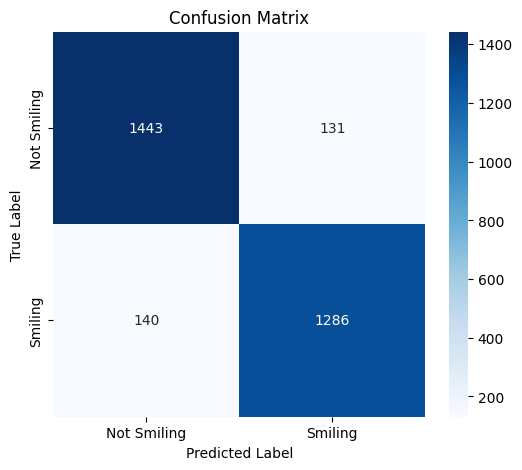

--- 5 Correct Classifications ---


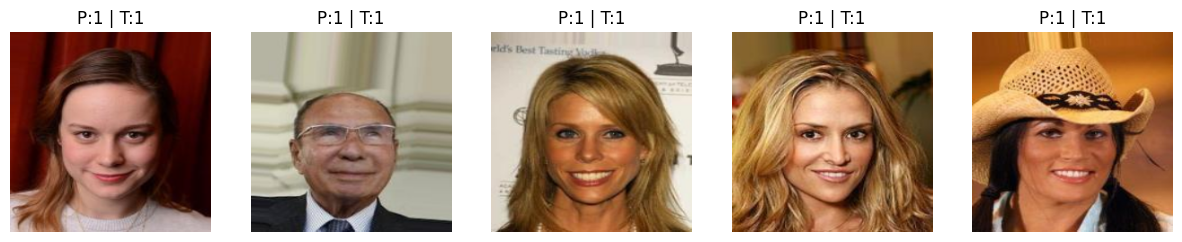


--- 5 Incorrect Classifications ---


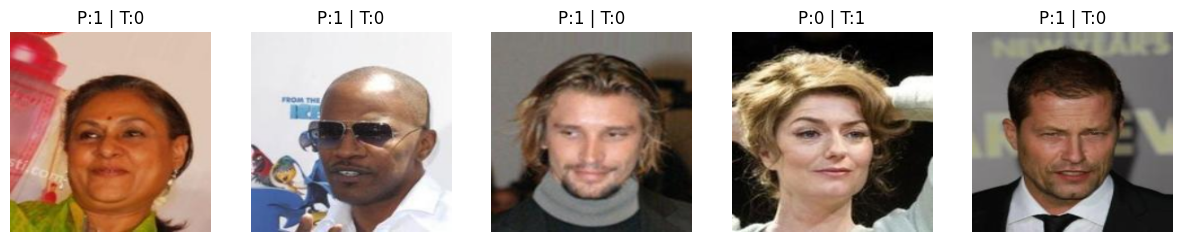

In [35]:
# --- 1. Compare Models and Select the Best One ---
# Get the highest validation accuracy achieved during training for both strategies
best_acc_s1 = max(history_s1['val_acc'])
best_acc_s2 = max(history_s2['val_acc'])

print(f"Strategy 1 Best Val Acc: {best_acc_s1:.4f}")
print(f"Strategy 2 Best Val Acc: {best_acc_s2:.4f}")

# Select the model with the higher validation accuracy
best_model = model_s2 if best_acc_s2 > best_acc_s1 else model_s1
print("Best model selected for testing.")

# --- 2. Define Evaluation Function ---
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

def evaluate_model(model, test_loader):
    """
    Evaluates the model on the test set, prints accuracy,
    and plots the confusion matrix.
    """
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No need to track gradients during evaluation
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1)

            # Forward pass
            outputs = model(inputs)
            # Apply sigmoid and threshold at 0.5 to get binary predictions (0 or 1)
            preds = torch.sigmoid(outputs) > 0.5

            # Store predictions and labels for metrics calculation
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate Accuracy
    acc = accuracy_score(all_labels, all_preds)
    print(f"Test Set Accuracy: {acc:.4f}")

    # Generate and Plot Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Smiling', 'Smiling'],
                yticklabels=['Not Smiling', 'Smiling'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

    return all_preds, all_labels

# Run evaluation on the test set
predictions, true_labels = evaluate_model(best_model, test_loader)


# --- 3. Define Visualization Function ---
def visualize_predictions(model, loader):
    """
    Visualizes 5 correct and 5 incorrect predictions from the dataset.
    """
    model.eval()
    correct_imgs = []
    incorrect_imgs = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs) > 0.5

            # Iterate through examples in the batch
            for i in range(inputs.size(0)):
                # Convert Tensor (C, H, W) to Image format (H, W, C) for plotting
                img = inputs[i].cpu().permute(1, 2, 0)

                # Denormalize the image (reverse the normalization applied in transforms)
                # to display correct colors
                mean = torch.tensor([0.485, 0.456, 0.406])
                std = torch.tensor([0.229, 0.224, 0.225])
                img = img * std + mean
                img = torch.clamp(img, 0, 1) # Ensure values are between 0 and 1

                is_correct = (preds[i] == labels[i]).item()

                # Collect 5 correct examples
                if is_correct and len(correct_imgs) < 5:
                    correct_imgs.append((img, preds[i].item(), labels[i].item()))
                # Collect 5 incorrect examples
                elif not is_correct and len(incorrect_imgs) < 5:
                    incorrect_imgs.append((img, preds[i].item(), labels[i].item()))

                # Stop if we have enough examples
                if len(correct_imgs) >= 5 and len(incorrect_imgs) >= 5:
                    break
            if len(correct_imgs) >= 5 and len(incorrect_imgs) >= 5:
                break

    # Plotting the results
    print("--- 5 Correct Classifications ---")
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i, (img, pred, true) in enumerate(correct_imgs):
        axes[i].imshow(img)
        axes[i].set_title(f"P:{int(pred)} | T:{int(true)}")
        axes[i].axis('off')
    plt.show()

    print("\n--- 5 Incorrect Classifications ---")
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for i, (img, pred, true) in enumerate(incorrect_imgs):
        axes[i].imshow(img)
        axes[i].set_title(f"P:{int(pred)} | T:{int(true)}")
        axes[i].axis('off')
    plt.show()

# Run visualization
visualize_predictions(best_model, test_loader)